# Explore Sentinel-2


In [1]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona
from shapely.geometry import Point

Need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down the username and password.

In [2]:
user = 'angelawu' 
password = 'jKV300Scv1e' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

Create the `.shp` file for Brazil

In [3]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [4]:
brazil = countries[countries.name == "Brazil"]
brazil

pop_est      continent    name iso_a3  gdp_md_est  \
29  207353391  South America  Brazil    BRA   3081000.0   

                                             geometry  
29  POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...

In [5]:
brazil.to_file('../data/Sentinel2/Brazil.shp')

Read Brazil.shp

In [6]:
brazil = gpd.read_file('../data/Sentinel2/Brazil.shp')
brazil

pop_est      continent    name iso_a3  gdp_md_est  \
0  207353391  South America  Brazil    BRA   3081000.0   

                                            geometry  
0  POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...

In [7]:
brazil.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Brazil.shp polygon is (lon, lat)
brazil_lon = brazil.centroid.x
brazil_lat = brazil.centroid.y

# a small number for zoom_start, more zoom out the image is
m = folium.Map([brazil_lat, brazil_lon], zoom_start=4)

folium.GeoJson(brazil).add_to(m)

# area of interest has lat, lon of (-10.883689, -44.005800)
point_of_interest_lat, point_of_interest_lon = -10.883689, -44.005800
# Point takes lon, lat
folium.GeoJson(Point(point_of_interest_lon, point_of_interest_lat)).add_to(m)
m

Draw a Polygon around point of interest

In [10]:
point_of_interest_len = 0.3
area_of_interest = Polygon([[point_of_interest_lon-point_of_interest_len, point_of_interest_lat-point_of_interest_len], 
                           [point_of_interest_lon-point_of_interest_len, point_of_interest_lat+point_of_interest_len], 
                           [point_of_interest_lon+point_of_interest_len, point_of_interest_lat+point_of_interest_len], 
                           [point_of_interest_lon+point_of_interest_len, point_of_interest_lat-point_of_interest_len]])

In [11]:
folium.GeoJson(area_of_interest).add_to(m)
m

Obtain Sentinel-2 image for the area of interest

In [12]:
products = api.query(area_of_interest,
                     date = ('20190601', '20190626'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10))

In [13]:
len(products)

31

In [14]:
products_gdf = api.to_geodataframe(products)
# Calculate the size of each product and remove all products less than 1GB
products_gdf['size'] = products_gdf.apply(lambda row: row['summary'].split('Size: ')[1], axis = 1) 
products_gdf['size_large'] = products_gdf.apply(lambda row: row['size'].find('GB')>0, axis = 1) 
products_gdf_sorted = products_gdf[products_gdf['size_large']].sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

/usr/local/lib/python3.5/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


waterpercentage  cloudcoverpercentage  \
c5f60a53-f88f-40cf-a306-19b4fb7e712e         0.095805              0.004681   
a0d2d238-2c80-4e81-83b5-7cdca6d2c696         0.009562              0.007339   
f1c2b51a-6657-4dc0-9e63-074f4e37da24         0.641654              0.008746   
e82528f7-769f-4a2f-9d49-83b71db2e1e6         0.102080              0.038043   
6fbe74d2-13a6-4a4b-9071-149f710247ee         0.009330              0.044141   
1a5e8304-9d3d-442c-a5a3-db4848a68200         0.612961              0.880226   
0f67bcd4-70d7-4da1-82f0-8045574d5068         0.095005              1.199329   
14cec77f-252b-4d93-bfe4-d04bd5599ed8         0.608322              2.066028   
71696a62-b48c-4829-b292-771c78022efb         0.009363              5.958049   
2bf3f517-dce6-42d3-8c6c-96f2fee7fba4         0.401435              7.194409   

                                                                               filename  \
c5f60a53-f88f-40cf-a306-19b4fb7e712e  S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_2...   
a0d2d238-2c80-4e81-83b5-7cdca6d2c696  S2B_MSIL2A_20190616T131249_N0212_R138_T23LPJ_2...   
f1c2b51a-6657-4dc0-9e63-074f4e37da24  S2A_MSIL2A_20190601T131251_N0212_R138_T23LPH_2...   
e82528f7-769f-4a2f-9d49-83b71db2e1e6  S2B_MSIL2A_20190619T132239_N0212_R038_T23LNJ_2...   
6fbe74d2-13a6-4a4b-9071-149f710247ee  S2A_MSIL2A_20190601T131251_N0212_R138_T23LPJ_2...   
1a5e8304-9d3d-442c-a5a3-db4848a68200  S2B_MSIL2A_20190616T131249_N0212_R138_T23LPH_2...   
0f67bcd4-70d7-4da1-82f0-8045574d5068  S2A_MSIL2A_20190614T132241_N0212_R038_T23LNJ_2...   
14cec77f-252b-4d93-bfe4-d04bd5599ed8  S2A_MSIL2A_20190621T131251_N0212_R138_T23LPH_2...   
71696a62-b48c-4829-b292-771c78022efb  S2B_MSIL2A_20190606T131249_N0212_R138_T23LPJ_2...   
2bf3f517-dce6-42d3-8c6c-96f2fee7fba4  S2B_MSIL2A_20190606T131249_N0212_R138_T23LPH_2...   

                                               beginposition  \
c5f60a53-f88f-40cf-a306-19b4fb7e712e 2019-06-04 13:22:41.024   
a0d2d238-2c80-4e81-83b5-7cdca6d2c696 2019-06-16 13:12:49.024   
f1c2b51a-6657-4dc0-9e63-074f4e37da24 2019-06-01 13:12:51.024   
e82528f7-769f-4a2f-9d49-83b71db2e1e6 2019-06-19 13:22:39.024   
6fbe74d2-13a6-4a4b-9071-149f710247ee 2019-06-01 13:12:51.024   
1a5e8304-9d3d-442c-a5a3-db4848a68200 2019-06-16 13:12:49.024   
0f67bcd4-70d7-4da1-82f0-8045574d5068 2019-06-14 13:22:41.024   
14cec77f-252b-4d93-bfe4-d04bd5599ed8 2019-06-21 13:12:51.024   
71696a62-b48c-4829-b292-771c78022efb 2019-06-06 13:12:49.024   
2bf3f517-dce6-42d3-8c6c-96f2fee7fba4 2019-06-06 13:12:49.024   

                                      highprobacloudspercentage format  \
c5f60a53-f88f-40cf-a306-19b4fb7e712e                   0.000898   SAFE   
a0d2d238-2c80-4e81-83b5-7cdca6d2c696                   0.000889   SAFE   
f1c2b51a-6657-4dc0-9e63-074f4e37da24                   0.001374   SAFE   
e82528f7-769f-4a2f-9d49-83b71db2e1e6                   0.016351   SAFE   
6fbe74d2-13a6-4a4b-9071-149f710247ee                   0.006566   SAFE   
1a5e8304-9d3d-442c-a5a3-db4848a68200                   0.092365   SAFE   
0f67bcd4-70d7-4da1-82f0-8045574d5068                   0.675085   SAFE   
14cec77f-252b-4d93-bfe4-d04bd5599ed8                   1.464740   SAFE   
71696a62-b48c-4829-b292-771c78022efb                   0.343469   SAFE   
2bf3f517-dce6-42d3-8c6c-96f2fee7fba4                   5.054675   SAFE   

                                      relativeorbitnumber  \
c5f60a53-f88f-40cf-a306-19b4fb7e712e                   38   
a0d2d238-2c80-4e81-83b5-7cdca6d2c696                  138   
f1c2b51a-6657-4dc0-9e63-074f4e37da24                  138   
e82528f7-769f-4a2f-9d49-83b71db2e1e6                   38   
6fbe74d2-13a6-4a4b-9071-149f710247ee                  138   
1a5e8304-9d3d-442c-a5a3-db4848a68200                  138   
0f67bcd4-70d7-4da1-82f0-8045574d5068                   38   
14cec77f-252b-4d93-bfe4-d04bd5599ed8                  138   
71696a62-b48c-4829-b292-771c78022efb                  138   
2bf3f517-dce6-42d3-8c6c-96f2fee7fba4

Interested in the first satellite image since this has the least cloud coverage of all available images.  
If we want ton download all images at once with api.download_all() function.

In [15]:
product_index = products_gdf_sorted.index.values[0]
product_index

'c5f60a53-f88f-40cf-a306-19b4fb7e712e'

In [148]:
api.download(product_index, directory_path='../data/Sentinel2')

Downloading: 100%|██████████| 1.10G/1.10G [03:51<00:00, 4.76MB/s]
MD5 checksumming: 100%|██████████| 1.10G/1.10G [00:05<00:00, 214MB/s]


{'Creation Date': datetime.datetime(2019, 6, 4, 23, 14, 41, 252000),
 'Ingestion Date': datetime.datetime(2019, 6, 4, 23, 5, 47, 571000),
 'Online': True,
 'date': datetime.datetime(2019, 6, 4, 13, 22, 41, 24000),
 'downloaded_bytes': 1101731919,
 'footprint': 'POLYGON((-43.99649 -10.586664213987294,-44.00049 -10.60491077277994,-44.03293 -10.753587838983208,-44.065887 -10.90217582913326,-44.074585 -10.942410045670893,-45.000183 -10.943932182721111,-45.000183 -9.950865356111207,-43.998505 -9.949365935598653,-43.99649 -10.586664213987294))',
 'id': 'c5f60a53-f88f-40cf-a306-19b4fb7e712e',
 'md5': '4F96F74FCA1183FBEED6BE5F0D2F9262',
 'path': '../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.zip',
 'size': 1101731919,
 'title': 'S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('c5f60a53-f88f-40cf-a306-19b4fb7e712e')/$value"}

In [16]:
product_id = products_gdf_sorted.at[product_index, 'identifier']

In [150]:
!unzip ../data/Sentinel2/{product_id}.zip -d ../data/Sentinel2

Archive:  ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.zip
   creating: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/INSPIRE.xml  
   creating: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/rep_info/
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/rep_info/S2_PDI_Level-2A_Tile_Metadata.xsd  
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/rep_info/S2_PDI_Level-2A_Datastrip_Metadata.xsd  
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/rep_info/S2_User_Product_Level-2A_Metadata.xsd  
   creating: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/HTML/
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T13

 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/GRANULE/L2A_T23LNJ_A020627_20190604T132235/QI_DATA/MSK_DETFOO_B10.gml  
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/GRANULE/L2A_T23LNJ_A020627_20190604T132235/QI_DATA/GENERAL_QUALITY.xml  
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/GRANULE/L2A_T23LNJ_A020627_20190604T132235/QI_DATA/MSK_SATURA_B8A.gml  
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/GRANULE/L2A_T23LNJ_A020627_20190604T132235/QI_DATA/MSK_DETFOO_B05.gml  
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/GRANULE/L2A_T23LNJ_A020627_20190604T132235/QI_DATA/MSK_DETFOO_B11.gml  
 extracting: ../data/Sentinel2/S2A_MSIL2A_20190604T132241_N0212_R038_T23LNJ_20190604T153923.SAFE/GRANULE/L2A_T23LNJ_A020627_20190604T132235/QI_DATA/MSK_SA

Create RGB image on the product tile

In [17]:
product_subfolder = !ls ../data/Sentinel2/{product_id}.SAFE/GRANULE
product_subfolder = product_subfolder[0]
product_subfolder

'L2A_T23LNJ_A020627_20190604T132235'

In [18]:
R10 = '../data/Sentinel2/{}.SAFE/GRANULE/{}/IMG_DATA/R10m/'.format(product_id, product_subfolder)

In [19]:
# Band 2 - Blue
# Band 3 - Green
# Band 4 - Red
# Band 8 - NIR
b2_file = !ls {R10} | grep B02
b3_file = !ls {R10} | grep B03
b4_file = !ls {R10} | grep B04
b8_file = !ls {R10} | grep B08

In [20]:
b2 = rio.open(R10+b2_file[0])
b3 = rio.open(R10+b3_file[0])
b4 = rio.open(R10+b4_file[0])
b8 = rio.open(R10+b8_file[0])

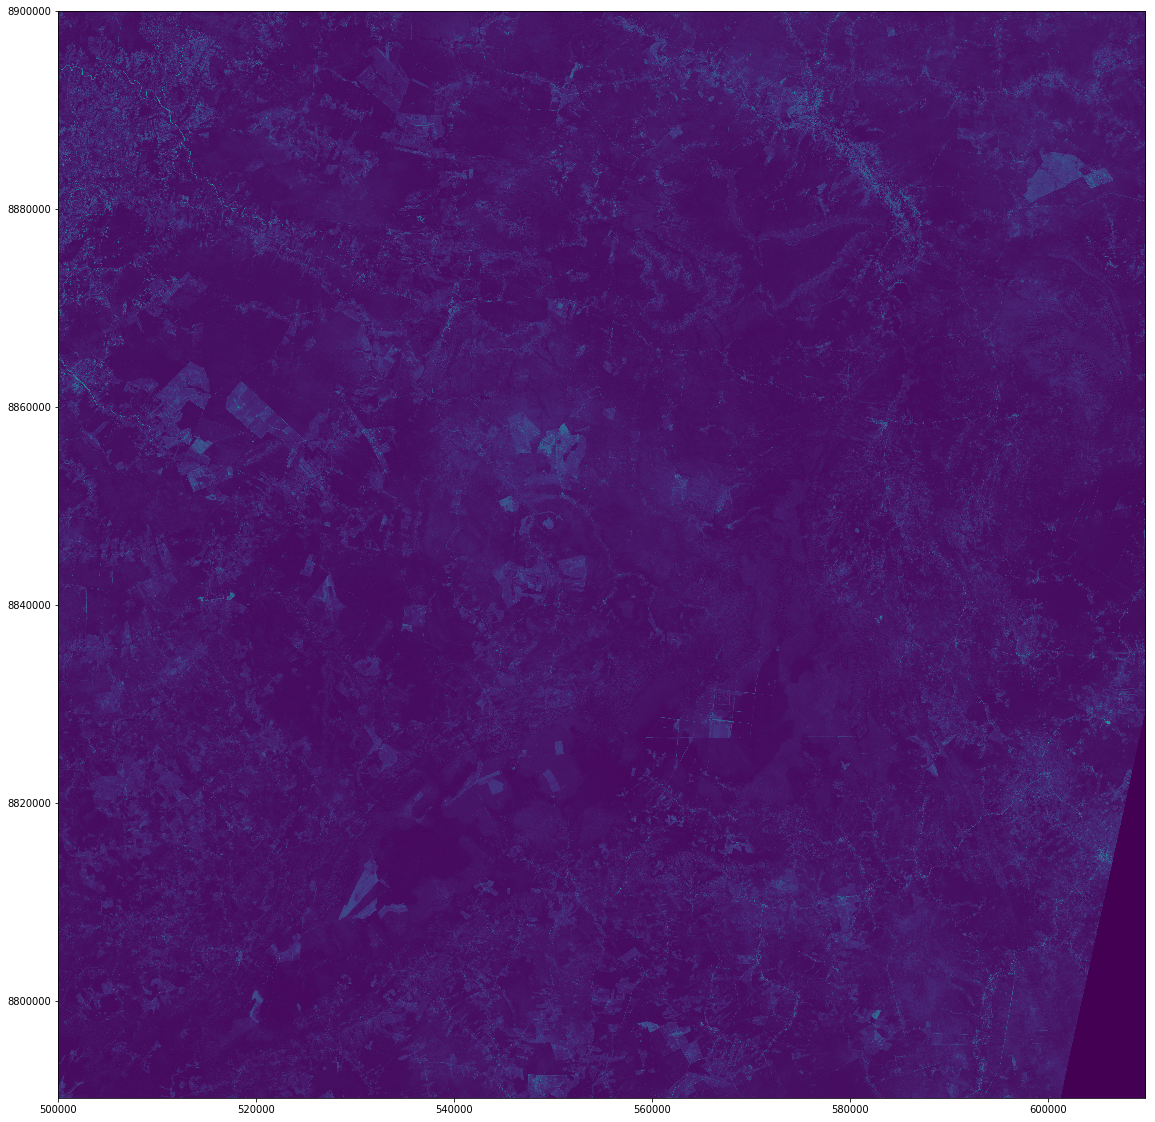

In [21]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(b4, ax=ax)
plt.show()

In [22]:
# Band 2 - Blue
# Band 3 - Green
# Band 4 - Red
# Band 8 - NIR

# Read the grid values into numpy arrays
# Note the shape is (1, x, y)
red = b4.read()
green = b3.read()
blue = b2.read()

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.06252235268409602
0.0 - 1.0 mean: 0.06219403320656403
0.0 - 1.0 mean: 0.03767743853072082


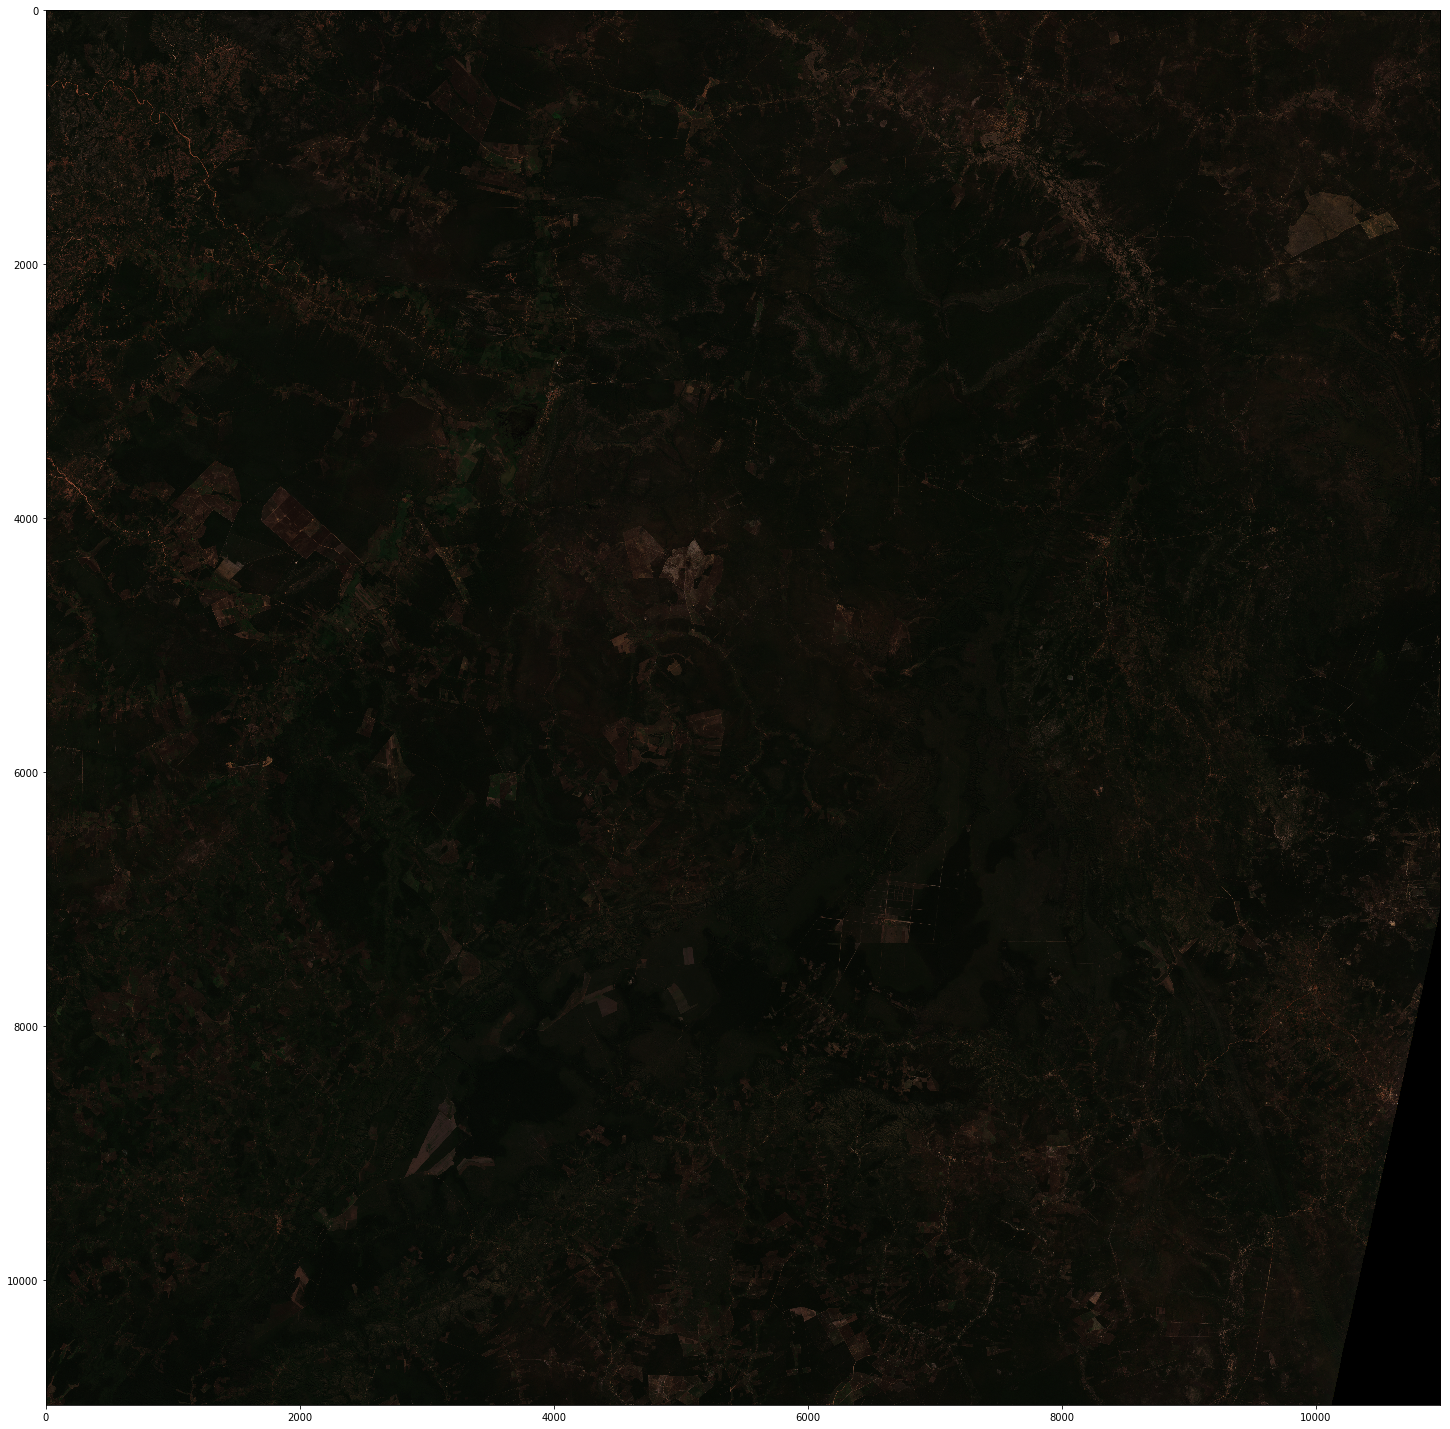

In [23]:
# Create RGB natural color composite
rgb = np.dstack((redn.squeeze(), greenn.squeeze(), bluen.squeeze()))

# Let's see how our color composite looks like
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(rgb)
plt.tight_layout()

Create NDVI image

In [24]:
red = b4.read()
nir = b8.read()

In [25]:
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [26]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

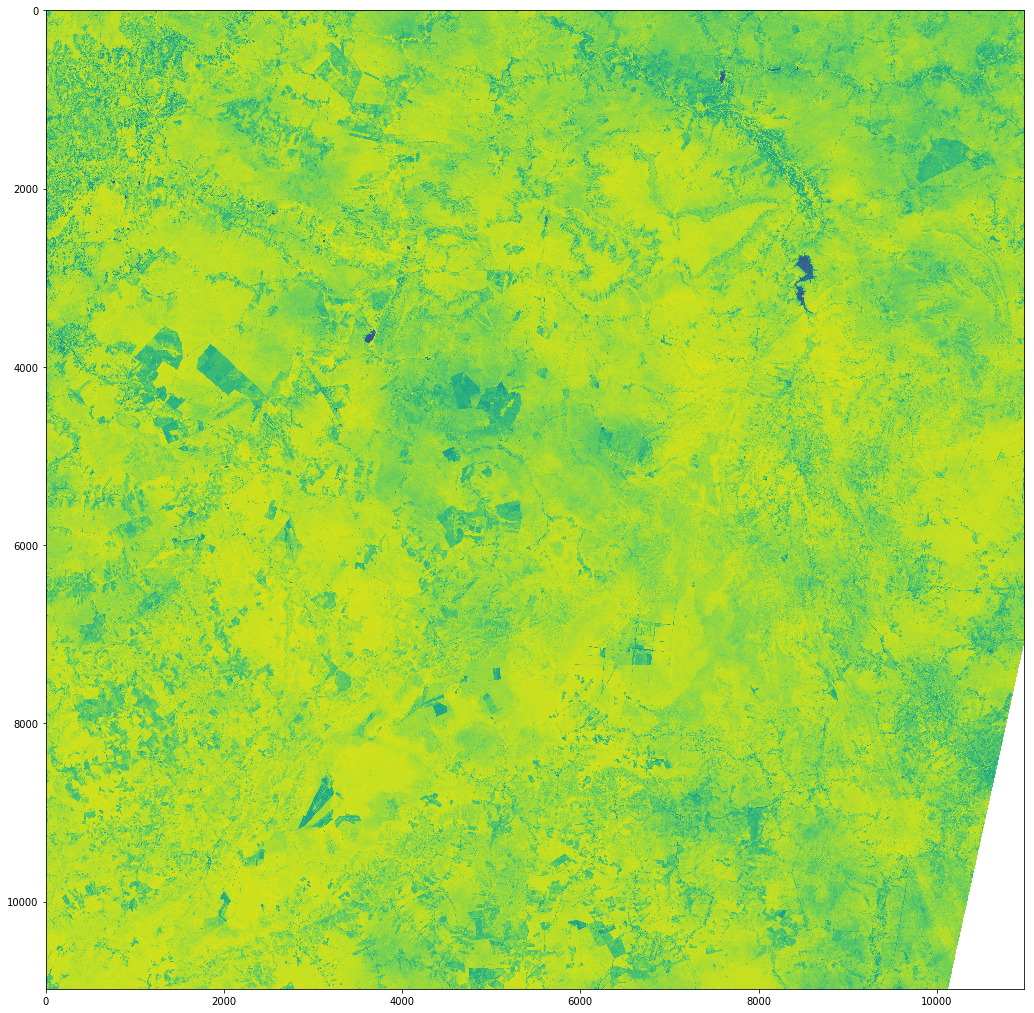

<function matplotlib.pyplot.show(*args, **kw)>

In [27]:
ndvi = rio.open(r"NDVI.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(ndvi.read(1))
plt.show